# Implementing a Neural Network with NumPy

Deep Learning has been making inroads with problems in many domains, includings ones that have previously been very difficult to solve, such as computer vision and voice recognition. It is a testament to its popularity that multiple open source frameworks and software packages are now available to make implementing your own neural network much quicker than before: Tensorflow, Torch, MXnet, Keras, Caffe and many more.

<img src="https://bids.berkeley.edu/sites/default/files/styles/400x225/public/projects/numpy_project_page.jpg" alt="NumPy is maintained by the Berkeley Institute for Data Science." style="float:left;width:150px;height:85px;">
However, higher level libraries abstract away the fundamental aspects of a neural network, namely **backpropagation** and **gradient descent**. Taking a cue from Udacity's Deep Learning course, I've followed the lead of the course instructors and built my first neural network for better understanding its mechanics. For this project, I will import only `NumPy` to construct a single hidden layer neural network, then use it on a time series regression problem with a publicly available bike sharing dataset. The code here is based on their course content with my own contribution to extend the functionality. 

Why is `Numpy` useful in constructing (simple) neural networks? It's because at the most fundamental level, all neural networks are computational graphs where mathematical operations are performed on n-dimensional arrays (also called tensors). Linear algebra is the branch of mathematics that deals with these problems. To solve them computationally, Python has the library `NumPy`, which along with the other scientific computing packages `SciPy` and `matplotlib`, implement a lot of the functionality of MATLAB for solving linear algebra problems. It relies on lower level libraries such as `BLAS` and `LAPACK` in `C` or `FORTRAN` that allow these computations to be done efficiently.

Let's lay out the basic components of the network we'll be building.

- Input layer
- Single hidden layer with sigmoid activation
- Output layer with no activation

The associated weights of these layers will need to be implemented, and biases are left out in this project for simplicity. We will construct a `NeuralNetwork()` class and implement the appropriate methods to train the network. The following steps will be followed:

<u>Forward propagation</u>
1. The input vector of one training sample is multiplied by the set of weights from the input to hidden layer
2. The sum of these weighted inputs are passed through sigmoid activation
3. These hidden layer outputs are multiplied by another set of weights from the hidden to outer layer
4. The final layer activation is applied to these inputs to give the final output. For simplicity, this network will use $f(x) = x$ as its activation function.

<u>Backpropagation</u>
1. The prediction error is calculated, which in this case of regression is subtraction from the value of the label 
2. The error allotted to the hidden-to-output weights is calculated by the dot product of the weights and the output errors
3. The gradient to be applied during gradient descent for the weight update of the input-to-hidden layer is derived the derivative of the sigmoid activation function, which is $s'(x) = s(x)(1 - s(x))$
4. We scale the resulting weight update values using our learning rate hyperparameter, then update all the weights simultaneously after one forward and backward pass.

After a random batch of samples of fixed size have been processed, the weights will be updated and another random batch will be selected for the next training pass. This is also known as **Stochastic Gradient Descent (SGD)**. 

The following are the hyperparameters that will also need to be implemented:

- learning rate
- number of hidden units
- number of training passes

## Constructing the network

As promised, using only `NumPy` for our `NeuralNetwork()` class:

In [1]:
import numpy as np

In [2]:
class NeuralNetwork(object):
    def __init__(self, input_nodes, hidden_nodes, output_nodes, learning_rate):
        self.input_nodes = input_nodes
        self.hidden_nodes = hidden_nodes
        self.output_nodes = output_nodes

        self.weights_input_to_hidden = np.random.normal(0.0, self.hidden_nodes**-0.5, 
                                                        (self.hidden_nodes, self.input_nodes))

        self.weights_hidden_to_output = np.random.normal(0.0, self.output_nodes**-0.5, 
                                                         (self.output_nodes, self.hidden_nodes))
        self.lr = learning_rate
        
        def sigmoid(x):
            return 1/(1+np.exp(-x))
        self.activation_function = sigmoid
    
    def train(self, inputs_list, targets_list):
        inputs = np.array(inputs_list, ndmin=2).T
        targets = np.array(targets_list, ndmin=2).T
        
        # Forward Pass
        hidden_inputs = np.dot(self.weights_input_to_hidden,inputs)
        #print(hidden_inputs)
        hidden_outputs = self.activation_function(hidden_inputs)

        final_inputs = np.dot(self.weights_hidden_to_output, hidden_outputs)
        final_outputs = final_inputs

        # Backward pass 
        output_errors = targets - final_outputs

        hidden_errors = np.dot(self.weights_hidden_to_output.T,output_errors)
        hidden_grad = hidden_outputs * (1.0 - hidden_outputs)
        
        self.weights_hidden_to_output += self.lr * np.dot(hidden_outputs, output_errors).T
        self.weights_input_to_hidden += self.lr * np.dot((hidden_errors*hidden_grad), inputs.T)
 
        
    def run(self, inputs_list):
        inputs = np.array(inputs_list, ndmin=2).T
        
        # Hidden layer
        hidden_inputs = np.dot(self.weights_input_to_hidden, inputs)
        hidden_outputs = self.activation_function(hidden_inputs)
        
        # Output layer
        final_inputs = np.dot(self.weights_hidden_to_output, hidden_outputs)
        final_outputs = final_inputs
        
        return final_outputs

We also define the cost function or this regression problem to be the Mean Squared Error:

In [3]:
def MSE(y, Y):
    return np.mean((y-Y)**2)

## Testing the network: Bikeshare dataset

In order to test our newly constructed neural network, let's apply it to a publicly available dataset (collected by researchers from the University of Porto) to predict bike usage. We'll be importing our usual libraries for data wrangling and visualisation.

In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import sys
%matplotlib inline

In [5]:
rides = pd.read_csv('assets/numpy_net/hour.csv')

## Exploratory Data Analysis

Our dataset tells the number of bike riders for each hour of each day in the column `cnt`, which we will use as our target variable, in the period January 1 2011 to December 31 2012. We also have a number of features, including meteorological data. This will be a time series regression problem.

In [7]:
rides.head()

,instant,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,2011-01-01,1,0,1,0,0,6,0,1,0.24,0.2879,0.81,0.0,3,13,16
1,2,2011-01-01,1,0,1,1,0,6,0,1,0.22,0.2727,0.80,0.0,8,32,40
2,3,2011-01-01,1,0,1,2,0,6,0,1,0.22,0.2727,0.80,0.0,5,27,32
3,4,2011-01-01,1,0,1,3,0,6,0,1,0.24,0.2879,0.75,0.0,3,10,13
4,5,2011-01-01,1,0,1,4,0,6,0,1,0.24,0.2879,0.75,0.0,0,1,1


In [9]:
print(min(rides.dteday))
print(max(rides.dteday))

2011-01-01
2012-12-31


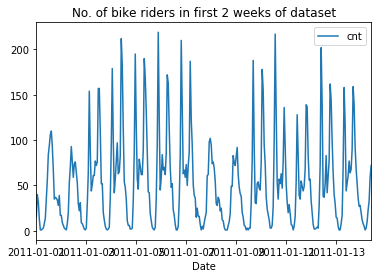

In [13]:
rides[:24*14].plot(x='dteday', y='cnt')
plt.title("No. of bike riders in first 2 weeks of dataset")
plt.xlabel("Date")
plt.show()

### Dummy variables
For the categorical variables like season, weather, month, we'll make use of the `pandas` method `get_dummies()`.

In [14]:
dummy_fields = ['season', 'weathersit', 'mnth', 'hr', 'weekday']
for each in dummy_fields:
    dummies = pd.get_dummies(rides[each], prefix=each, drop_first=False)
    rides = pd.concat([rides, dummies], axis=1)

# dropping columns after we have the dummies
fields_to_drop = ['instant', 'dteday', 'season', 'weathersit','weekday', 'atemp', 'mnth', 'workingday', 'hr']
data = rides.drop(fields_to_drop, axis=1)
pd.set_option('max_columns',len(data.columns))
data.head()

,yr,holiday,temp,hum,windspeed,casual,registered,cnt,season_1,season_2,season_3,season_4,weathersit_1,weathersit_2,weathersit_3,weathersit_4,mnth_1,mnth_2,mnth_3,mnth_4,mnth_5,mnth_6,mnth_7,mnth_8,mnth_9,mnth_10,mnth_11,mnth_12,hr_0,hr_1,hr_2,hr_3,hr_4,hr_5,hr_6,hr_7,hr_8,hr_9,hr_10,hr_11,hr_12,hr_13,hr_14,hr_15,hr_16,hr_17,hr_18,hr_19,hr_20,hr_21,hr_22,hr_23,weekday_0,weekday_1,weekday_2,weekday_3,weekday_4,weekday_5,weekday_6
0,0,0,0.24,0.81,0.0,3,13,16,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
1,0,0,0.22,0.80,0.0,8,32,40,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
2,0,0,0.22,0.80,0.0,5,27,32,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
3,0,0,0.24,0.75,0.0,3,10,13,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
4,0,0,0.24,0.75,0.0,0,1,1,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1


The code block here standardises our non-categorical features. An alternative would be to use `StandardScaler()` in `scikit-learn`.

In [15]:
quant_features = ['casual', 'registered', 'cnt', 'temp', 'hum', 'windspeed']
# Store scalings in a dictionary so we can convert back later
scaled_features = {}
for each in quant_features:
    mean, std = data[each].mean(), data[each].std()
    scaled_features[each] = [mean, std]
    data.loc[:, each] = (data[each] - mean)/std

### Train/Validation/Test split

In lieu of the usual `train_test_split()` method, let's take the last 21 days of our time series data to use as a test set.

In [16]:
test_data = data[-21*24:]
data = data[:-21*24]

target_fields = ['cnt', 'casual', 'registered']
features, targets = data.drop(target_fields, axis=1), data[target_fields]
test_features, test_targets = test_data.drop(target_fields, axis=1), test_data[target_fields]

Then we further take out 60 days to use as our validation set.

In [17]:
train_features, train_targets = features[:-60*24], targets[:-60*24]
val_features, val_targets = features[-60*24:], targets[-60*24:]

## Training and Hyperparameter tuning

### Number of epochs
An epoch simplify signifies one pass of our randomly selected batch of the dataset through the neural network. The weights are updated at the end of each epoch. The balance that must be struck here is to train the network through sufficient epochs to converge, but not so high as to overfit and also waste computation cycles.

### Learning rate
This is a key hyperparameter that scales our weight updates. Too high a learning rate often causes a network to fail to converge at all; but at too low a learning rate, it would take too long.

### Number of hidden nodes
Our neural network model capacity is determined by this hyperparameter. The more hidden nodes we have, the more complicated our model can be, with the entailing problem of potential overfitting.

In [26]:
# Hyperparameters
epochs = 300
learning_rate = 0.1
hidden_nodes = 50
output_nodes = 1

N_i = train_features.shape[1]
network = NeuralNetwork(N_i, hidden_nodes, output_nodes, learning_rate)

losses = {'train':[], 'validation':[]}
for e in range(epochs):
    # SGD: Random batch of 128 records from our training data
    batch = np.random.choice(train_features.index, size=128)
    for record, target in zip(train_features.ix[batch].values, 
                              train_targets.ix[batch]['cnt']):
        network.train(record, target)
    
    train_loss = MSE(network.run(train_features), train_targets['cnt'].values)
    val_loss = MSE(network.run(val_features), val_targets['cnt'].values)
    sys.stdout.write("\rProgress: " + str(100 * e/float(epochs))[:4] \
                     + "% ... Training loss: " + str(train_loss)[:5] \
                     + " ... Validation loss: " + str(val_loss)[:5])
    
    losses['train'].append(train_loss)
    losses['validation'].append(val_loss)

Progress: 99.6% ... Training loss: 0.131 ... Validation loss: 0.153

It is always good practice to plot **learning curves** to check if our model has converged:

(0.007888620172173344, 1.3888953461651516)

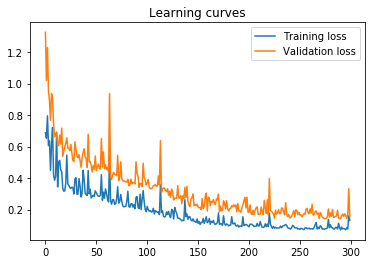

In [27]:
plt.plot(losses['train'], label='Training loss')
plt.plot(losses['validation'], label='Validation loss')
plt.title("Learning curves")
plt.legend()
plt.ylim()

It looks like our neural network has converged! Next we'll use it on our test set to see if it does a good job at predicting bike usage.

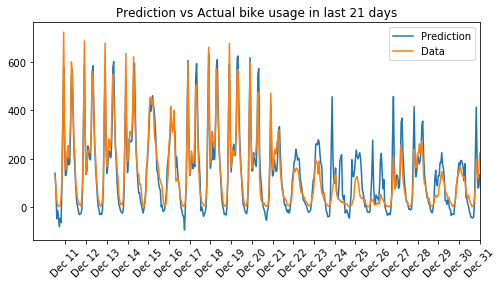

In [28]:
fig, ax = plt.subplots(figsize=(8,4))

mean, std = scaled_features['cnt']
predictions = network.run(test_features)*std + mean
plt.title("Prediction vs Actual bike usage in last 21 days")
ax.plot(predictions[0], label='Prediction')
ax.plot((test_targets['cnt']*std + mean).values, label='Data')
ax.set_xlim(right=len(predictions))
ax.legend()

dates = pd.to_datetime(rides.ix[test_data.index]['dteday'])
dates = dates.apply(lambda d: d.strftime('%b %d'))
ax.set_xticks(np.arange(len(dates))[12::24])
_ = ax.set_xticklabels(dates[12::24], rotation=45)

In [29]:
print("Training loss: " + str(MSE(network.run(train_features), train_targets['cnt'].values)))
print("Validation loss: " + str(MSE(network.run(val_features), val_targets['cnt'].values)))
print("Test loss: " + str(MSE(network.run(test_features), test_targets['cnt'].values)))

Training loss: 0.13135469879
Validation loss: 0.153528086585
Test loss: 0.126018132741


## Observations

Interestingly, the Test loss is comparable to the training loss and lower than the validation loss. While this remains to be investigated, we can say that in this instance the network has not overfitted, and predicts the test set quite well. The test loss shows that our test predictions are reasonably accurate.

Based on the graph above, the neural network's predictions capture the daily periodicity of the data quite well, and for normal working days the peaks corresponding to rush hour are more or less accurately predicted. However, during the public holidays around Christmas it overestimates bike usage, which tells us that the neural network hasn't learned that on those specific days fewer people use bikes. It remains to be investigated if other public holidays trip up our network as well.

Some potential solutions are to:

- Increase the training set time period. Currently it only contains one Christmas (Jan 2011 to Dec 2012 with the last 21+60 days held out for validation and testing respectively). If more years including Christmas were used for training, the neural network might be able learn to recognise those days as special.
- Explicitly model public holidays. Concretely, we could use one-hot encoding to create an extra feature column that shows which days are public holidays.

All in all, our network has performed rather well considering it only has one hidden layer, and lacks other features such as regularisation.